In [27]:
!pip install keras-tuner

# 1. Load libraries and Data


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [29]:
# Dataset of MNIST numbers
# It is a labeled dataset with images of 28x28 pixels
data_fetcher = keras.datasets.mnist

# 2. Fetch and split the data

In [30]:
(train_images,train_labels),(test_images,test_labels)=data_fetcher.load_data()

Sample image

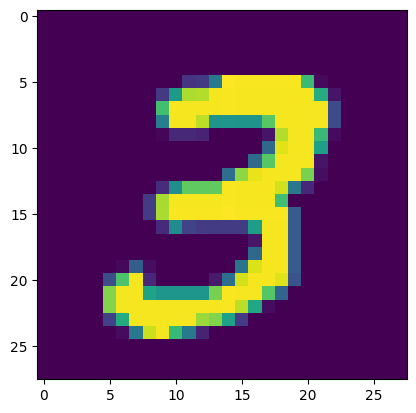

In [31]:
plt.imshow(train_images[7])

In [32]:
# Scaling the pixels to 0-1

train_images = train_images/255.0
test_images = test_images/255.0

In [33]:
# For CNN model we need a 3D Extra axis so we reshape the images
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)

# 3. Creating the function of the Model

In [34]:
def create_model(hyper_parameters):

  # create the model layers
  model = keras.Sequential([
        keras.layers.Conv2D(
           filters = hyper_parameters.Int('conv_1_filter',min_value=32,max_value=128,step=16),
           kernel_size=hyper_parameters.Choice('conv_1_kernel',values = [3,5]),
           activation='relu',
           input_shape=(28,28,1)
        ),
        keras.layers.Conv2D(
           filters = hyper_parameters.Int('conv_2_filter',min_value=32,max_value=64,step=16),
           kernel_size=hyper_parameters.Choice('conv_2_kernel',values = [3,5]),
           activation='relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hyper_parameters.Int('dense_1_units',min_value=32,max_value=128,step=16),
            activation='relu'
        ),
        keras.layers.Dense(10,activation='softmax')
    ])

  # compile the model
  model.compile(optimizer=keras.optimizers.Adam(hyper_parameters.Choice('learning_rate',values=[0.01,0.001])),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [35]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# 4. Initialize the Hyperparameter tuner

In [36]:
tuner_search = RandomSearch(create_model,
                            objective = 'val_accuracy',
                            max_trials=5,
                            directory='output',
                            project_name='number_classifier')

Reloading Tuner from output/number_classifier/tuner0.json


# 5. Run the Tuner search

In [37]:
tuner_search.search(train_images,train_labels,epochs=5,validation_split=0.1)

# 6. Get the best model

In [38]:
model = tuner_search.get_best_models()[0]

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 48)        480       
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 48)        57648     
                                                                 
 flatten (Flatten)           (None, 23232)             0         
                                                                 
 dense (Dense)               (None, 112)               2602096   
                                                                 
 dense_1 (Dense)             (None, 10)                1130      
                                                                 
Total params: 2661354 (10.15 MB)
Trainable params: 2661354 (10.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 7. Fit the model

In [40]:
model.fit(train_images,train_labels,epochs=10,validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 13s 7ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 0.0381 - val_accuracy: 0.9905
Epoch 2/10
1688/1688 [==============================] - 16s 9ms/step - loss: 0.0108 - accuracy: 0.9966 - val_loss: 0.0373 - val_accuracy: 0.9910
Epoch 3/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.0074 - accuracy: 0.9976 - val_loss: 0.0551 - val_accuracy: 0.9888
Epoch 4/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0542 - val_accuracy: 0.9902
Epoch 5/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0621 - val_accuracy: 0.9902
Epoch 6/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0582 - val_accuracy: 0.9913
Epoch 7/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0627 - val_accura

In [41]:
model.evaluate(test_images,test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0578 - accuracy: 0.9896


[0.05776961147785187, 0.9896000027656555]

# ====> 98.51% Accuracy...

In [47]:
model.save('Number_Predictor.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
test_images.shape

(10000, 28, 28, 1)

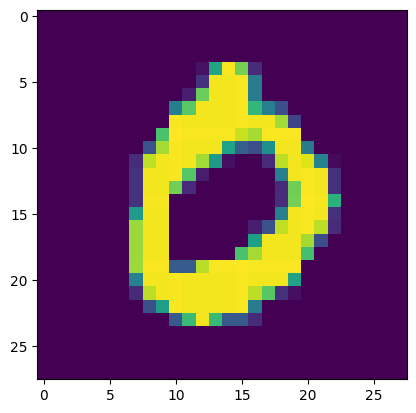

In [44]:
plt.imshow(test_images[3])

In [46]:
prediction = model.predict(test_images)
prediction[3]

313/313 [==============================] - 1s 4ms/step


array([1.0000000e+00, 3.1943360e-18, 1.6884298e-13, 9.0015487e-20,
       5.4876406e-17, 3.9787590e-15, 4.8807903e-13, 1.2761302e-10,
       5.6539158e-17, 5.4560745e-19], dtype=float32)

## WE need to convert the model in tensorflowjs interpretable format for our node server

In [49]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 73.2 MB/s eta 0:00:00


In [50]:
import tensorflowjs as tfjs

In [51]:
tfjs.converters.save_keras_model(model,'/content/')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
